In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from tqdm.auto import tqdm

%matplotlib inline
%config Completer.use_jedi = False

In [2]:
df_checks = pd.read_csv('data/checks.csv', sep=';')
df_active_studs = pd.read_csv('data/active_studs.csv')
df_groups = pd.read_csv('data/groups.csv', sep=';')

In [3]:
# Check that id is the primary key in tables where the user ID should be the primary key
# To avoid Cartesian product when JOIN columns
print(df_active_studs['student_id'].nunique() == df_active_studs['student_id'].shape[0])
print(df_groups['id'].nunique() == df_groups['id'].shape[0])

True
True


We see that in the table of payments - 1 user, 1 payment. In other words, "user_id" is the primary key. And the column "rev" - the average check of an individual user

In [4]:
print(df_checks['student_id'].nunique() == df_checks['student_id'].shape[0])

True


In [5]:
# Merge all tables into one
df_checks_active_studs = df_checks.merge(df_active_studs, how='outer', on='student_id')

In [6]:
# Intermediately check that there are no "nan" values in the "id" column
df_checks_active_studs.isna().sum()

student_id       0
rev           7949
dtype: int64

In [7]:
df_full = df_groups.merge(df_checks_active_studs, how='outer', left_on='id', right_on='student_id')
df_full.head()

id grp  student_id    rev
0  1489.0   B         NaN    NaN
1  1627.0   A      1627.0  990.0
2  1768.0   B         NaN    NaN
3  1783.0   B         NaN    NaN
4  1794.0   A         NaN    NaN

In [8]:
# Add a column of active and paid users
df_full['is_active'] = (df_full['student_id'] > 0).astype('int')
df_full['has_bought'] = (df_full['rev'] > 0).astype('int')

In [9]:
# From 2 columns with ID we form 1
def id_from_two(id1, id2):
    if id1 > 0:
        return id1
    if id2 > 0:
        return id2
    else:
        return np.nan
    
v = np.vectorize(id_from_two)
df_full['user_id'] = v(df_full['id'], df_full['student_id'])

c:\users\b\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in id_from_two (vectorized)
  outputs = ufunc(*inputs)


In [10]:
# We see that the new "user_id" column is missing "nan" values
df_full.isna().sum()

id               13
grp              13
student_id    66007
rev           73956
is_active         0
has_bought        0
user_id           0
dtype: int64

In [11]:
df_full = df_full.drop(['id', 'student_id'], axis=1)

In [12]:
df_full = df_full[['user_id', 'grp', 'is_active', 'has_bought', 'rev']]

In [13]:
df_full.head()

user_id grp  is_active  has_bought    rev
0   1489.0   B          0           0    NaN
1   1627.0   A          1           1  990.0
2   1768.0   B          0           0    NaN
3   1783.0   B          0           0    NaN
4   1794.0   A          0           0    NaN

We will select only **active users** from the consideration that a user who did not visit the site on the days of the experiment could not automatically buy the product. And since the experiment is based on the new payment mechanics. That user, who did not visit the site during the days of the experiment, simply physically could not "check out" the innovation in the form of a new payment mechanic.

In [14]:
df_full_active = df_full.query('is_active == 1')

In [15]:
# Percentage of users who bought relative to active
round(df_full_active['has_bought'].sum() / df_full_active.shape[0] * 100, 2)

6.37

In [16]:
df_full_active.head()

user_id grp  is_active  has_bought    rev
1    1627.0   A          1           1  990.0
10   2085.0   B          1           0    NaN
12   2215.0   B          1           0    NaN
39   3185.0   B          1           1  690.0
43   3391.0   A          1           0    NaN

We see that the medians (group **A = 690**, group **B = 880**) and mean (group **A = 861**, group **B = 1107**) mean checks of both groups differ

In [17]:
grp_a_b = df_full_active.groupby(['user_id', 'grp'], as_index=False) \
    .agg({'is_active': 'count', 'has_bought': ['mean', 'sum'], 
                  'rev': ['median', 'mean', 'count']})
temp_columns = ['user_id', 'grp', 'is_active_count', 'has_bought_mean', 'has_bounght_sum',
                   'rev_median', 'rev_mean', 'rev_count']
grp_a_b.columns = temp_columns


grp_a_b = grp_a_b.groupby('grp', as_index=False) \
    .agg({'is_active_count': 'count', 'has_bought_mean': ['mean', 'sum'], 
                  'rev_median': ['median', 'mean', 'count']})
temp_columns_1 = ['grp', 'is_active_count', 'active_buy_conv', 'times_bought',
                   'median_check', 'mean_check', 'check_count']
grp_a_b.columns = temp_columns_1

grp_a_b

grp  is_active_count  active_buy_conv  times_bought  median_check  \
0   A             1564         0.068414           107         690.0   
1   B             6913         0.062636           433         880.0   

    mean_check  check_count  
0   860.710280          107  
1  1106.997699          433

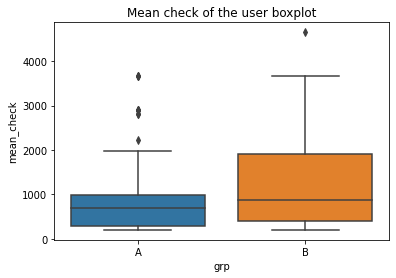

In [61]:
sns.boxplot(data=df_full_active, x='grp', y='rev')
plt.ylabel('mean_check')
plt.title('Mean check of the user boxplot');

In [18]:
pd.crosstab(df_full_active['grp'], df_full_active['has_bought'])

has_bought     0    1
grp                  
A           1457  107
B           6480  433

Since we have 2 categorical variables (groups A / B and bought / not bought), we use the chi-square statistical method for statistical comparison.
Outcome - **groups A and B** in terms of conversion into a purchase are statistically significant **do not differ**

In [46]:
# H0 - Null hypothesis - the groups are not statistically significantly different
# H1 - Alternative hypothesis - the groups are statistically significantly different

stat, p, dof, expected = stats.chi2_contingency(pd.crosstab(df_full_active['grp'], df_full_active['has_bought']))
print(stat, p)

alpha = 0.05
if p <= alpha:
    print('Reject H0')
else:
    print('Do not reject H0')

0.6204959154128902 0.4308630604023529
Не отклоняем Н0


In [62]:
# Now let's analyze the average checks
# You can already visually see that the data is not normally distributed
df_full_active['rev'].hist()
plt.xlabel('mean_check')
plt.ylabel('count')
plt.title('Распределение средних чеков пользователей');

In [47]:
# Also, the Shapiro-Wilk test showed that the data in the "rev" column is not normally distributed
# Because the pvalue is clearly less than the academic 0.05 and 0.01. (10^-21)
# The hypothesis of normal distribution is rejected
stats.shapiro(df_full_active['rev'].dropna())

ShapiroResult(statistic=0.865729808807373, pvalue=3.861868788701404e-21)

In [23]:
grp_a_rev = df_full_active.query('grp == "A"')['rev'].dropna()
grp_b_rev = df_full_active.query('grp == "B"')['rev'].dropna()

For non-normally distributed values, bootstrap is applicable. We use the average as a statistical function, since our outliers are insignificant.
The bootstrap method requires a representative sample. We do not have data that allowed us to say how representative the sample is (for example, city, gender, age ...).

In the bootstrap, from the average value of the data sample of group B, we subtract the average value of group A
**mean(B) - mean(A)**

Using bootstrap, I found that the **99% confidence interval** of the deviations of the mean values ​​of both groups is in the range **(113, 390)**. Which tells us that the **average pays** for groups A and B are **statistically significantly different** because the range does not include **0**.

Also, the level of **pvalue** (10^-6) tells us about the statistical difference, which is an order of magnitude less than 0.01

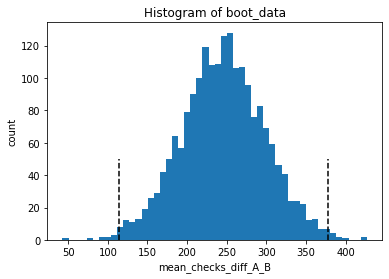

{'ci':                 0
 0.005  113.955715
 0.995  377.260529,
 'p_value': 2.8781732931022054e-06}

In [63]:
def get_bootstrap(
    grp_a,
    grp_b,
    boot_iterations=2000,
    statistic=np.mean,
    bootstrap_conf_level=0.99):
    
    boot_len = max(len(grp_a), len(grp_b))
    boot_data = []
    for i in range(boot_iterations):
        sample_a = grp_a.sample(boot_len, replace=True)
        sample_b = grp_b.sample(boot_len, replace=True)
        boot_data.append(statistic(sample_b) - statistic(sample_a))
            
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level)/2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
    
    # Visualisation
    plt.hist(pd_boot_data[0], bins=50)
    plt.vlines(ci, ymin=0, ymax=50, linestyles='--', colors='black')
    plt.xlabel('mean_checks_diff_A_B')
    plt.ylabel('count')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'ci': ci, 
            'p_value': p_value}
    
get_bootstrap(grp_a_rev, grp_b_rev, statistic=np.mean)

In [25]:
print(f'Кол-во наблюдений в группе А = {grp_a_rev.shape[0]}')
print(f'Кол-во наблюдений в группе B = {grp_b_rev.shape[0]}')

Кол-во наблюдений в группе А = 107
Кол-во наблюдений в группе B = 433


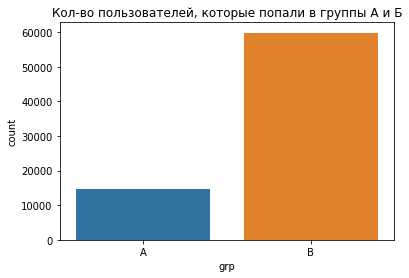

In [55]:
# Кол-во пользователей, которые попали в группу А и Б
sns.countplot(x=df_full['grp'], order=['A', 'B'])
plt.title('Кол-во пользователей, которые попали в группы А и Б');

**Conclusions:**

1. Conversion activity->purchase does not statistically significantly differ in groups A and B
2. But the average check in groups A and B differs statistically significantly and these differences lie in the 99% confidence interval (113, 390). That is, the average check of group B is on average (130 ... 390) rubles / dollars more than that of group A

Now, to interpret the results, it is necessary to clarify some nuances.
Usually, when conducting A / B tests, group A is the control group, group B is the test group. And in group B (the users on which we are conducting the experiment) there should be fewer users than in group A. In the same dataset, there are almost 5 times more users in group B than in group A.

**Which tells us either:**

    a) In fact, group A is the test group, and group B is the control group.
    or
    b) Groups are labeled incorrectly. And most of the users were sent to the test group, which is quite risky and contradicts the main idea of ​​the A / B test - an experiment with a minimum of risks.
    
**TOTAL**

1. If the statement is true that group A is a test group and group B is a control group, then we should not roll out a new payment system for new users, since test group A proved to be worse than control group B by (130...390) rubles / dollars for payment. Despite the fact that the conversion from visit to purchase remained unchanged.

2. If the statement is true that group A is the control group and group B is the test group, then we should roll out a new payment system for new users, since the test group B proved to be better than the control group A by (130 ... 390) rubles /dollars for payment. Despite the fact that the conversion from visit to purchase remained unchanged.